In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle

from os import listdir
from os.path import isfile, join
from pathlib import Path

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def gray2rgb(gray):

    rgb = np.stack((gray,)*3, axis=-1)

    return rgb
    

def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

In [2]:
def add_watermark(background_image_path,watermark_path, intensity_watermark,image_size,white_bool):
    #watermark should be jpg with white background
    #lower intensity_watermark leads to a more transparent watermark in the final image (less contrast)
    # white_bool is a bool that indicated if the watermark to add is white or black
    
    background_image = Image.open(background_image_path)
    background_image = background_image.resize(image_size)
    watermark = Image.open(watermark_path)

    #resize watermark to cover the entire background width without getting deformed
    w=int(background_image.size[0])
    h=int(watermark.size[1]*background_image.size[0]/watermark.size[0])
    watermark = watermark.resize((w,h))

    background_image=np.array(background_image)
    watermark=np.array(watermark)

    b=rescale_values(background_image,1,0)
    rgb=rescale_values(watermark,1,0)

    #turning watermark into grayscale
    r, g, blue = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 1-(0.2989 * r + 0.5870 * g + 0.1140 * blue)

    #padding watermark to be an image the same size as the background image
    white=np.ones((b.shape[0],b.shape[1]))
    white[0:gray.shape[0],0:gray.shape[1]]=gray

    # grayscale watermark with 3 channels
    gr=np.repeat(white[..., np.newaxis], 3, axis=2)

    if white_bool:
        im=1-b
        gr_p=rescale_values(gr,1,1-intensity_watermark)
        i_2=im*gr_p
        output_image=1-(i_2)
    else:
        im=rescale_values(b,1,0)
        gr_p=rescale_values(gr,1,1-intensity_watermark)
        output_image=im*gr_p
     
    #output_image=0
    return output_image

    

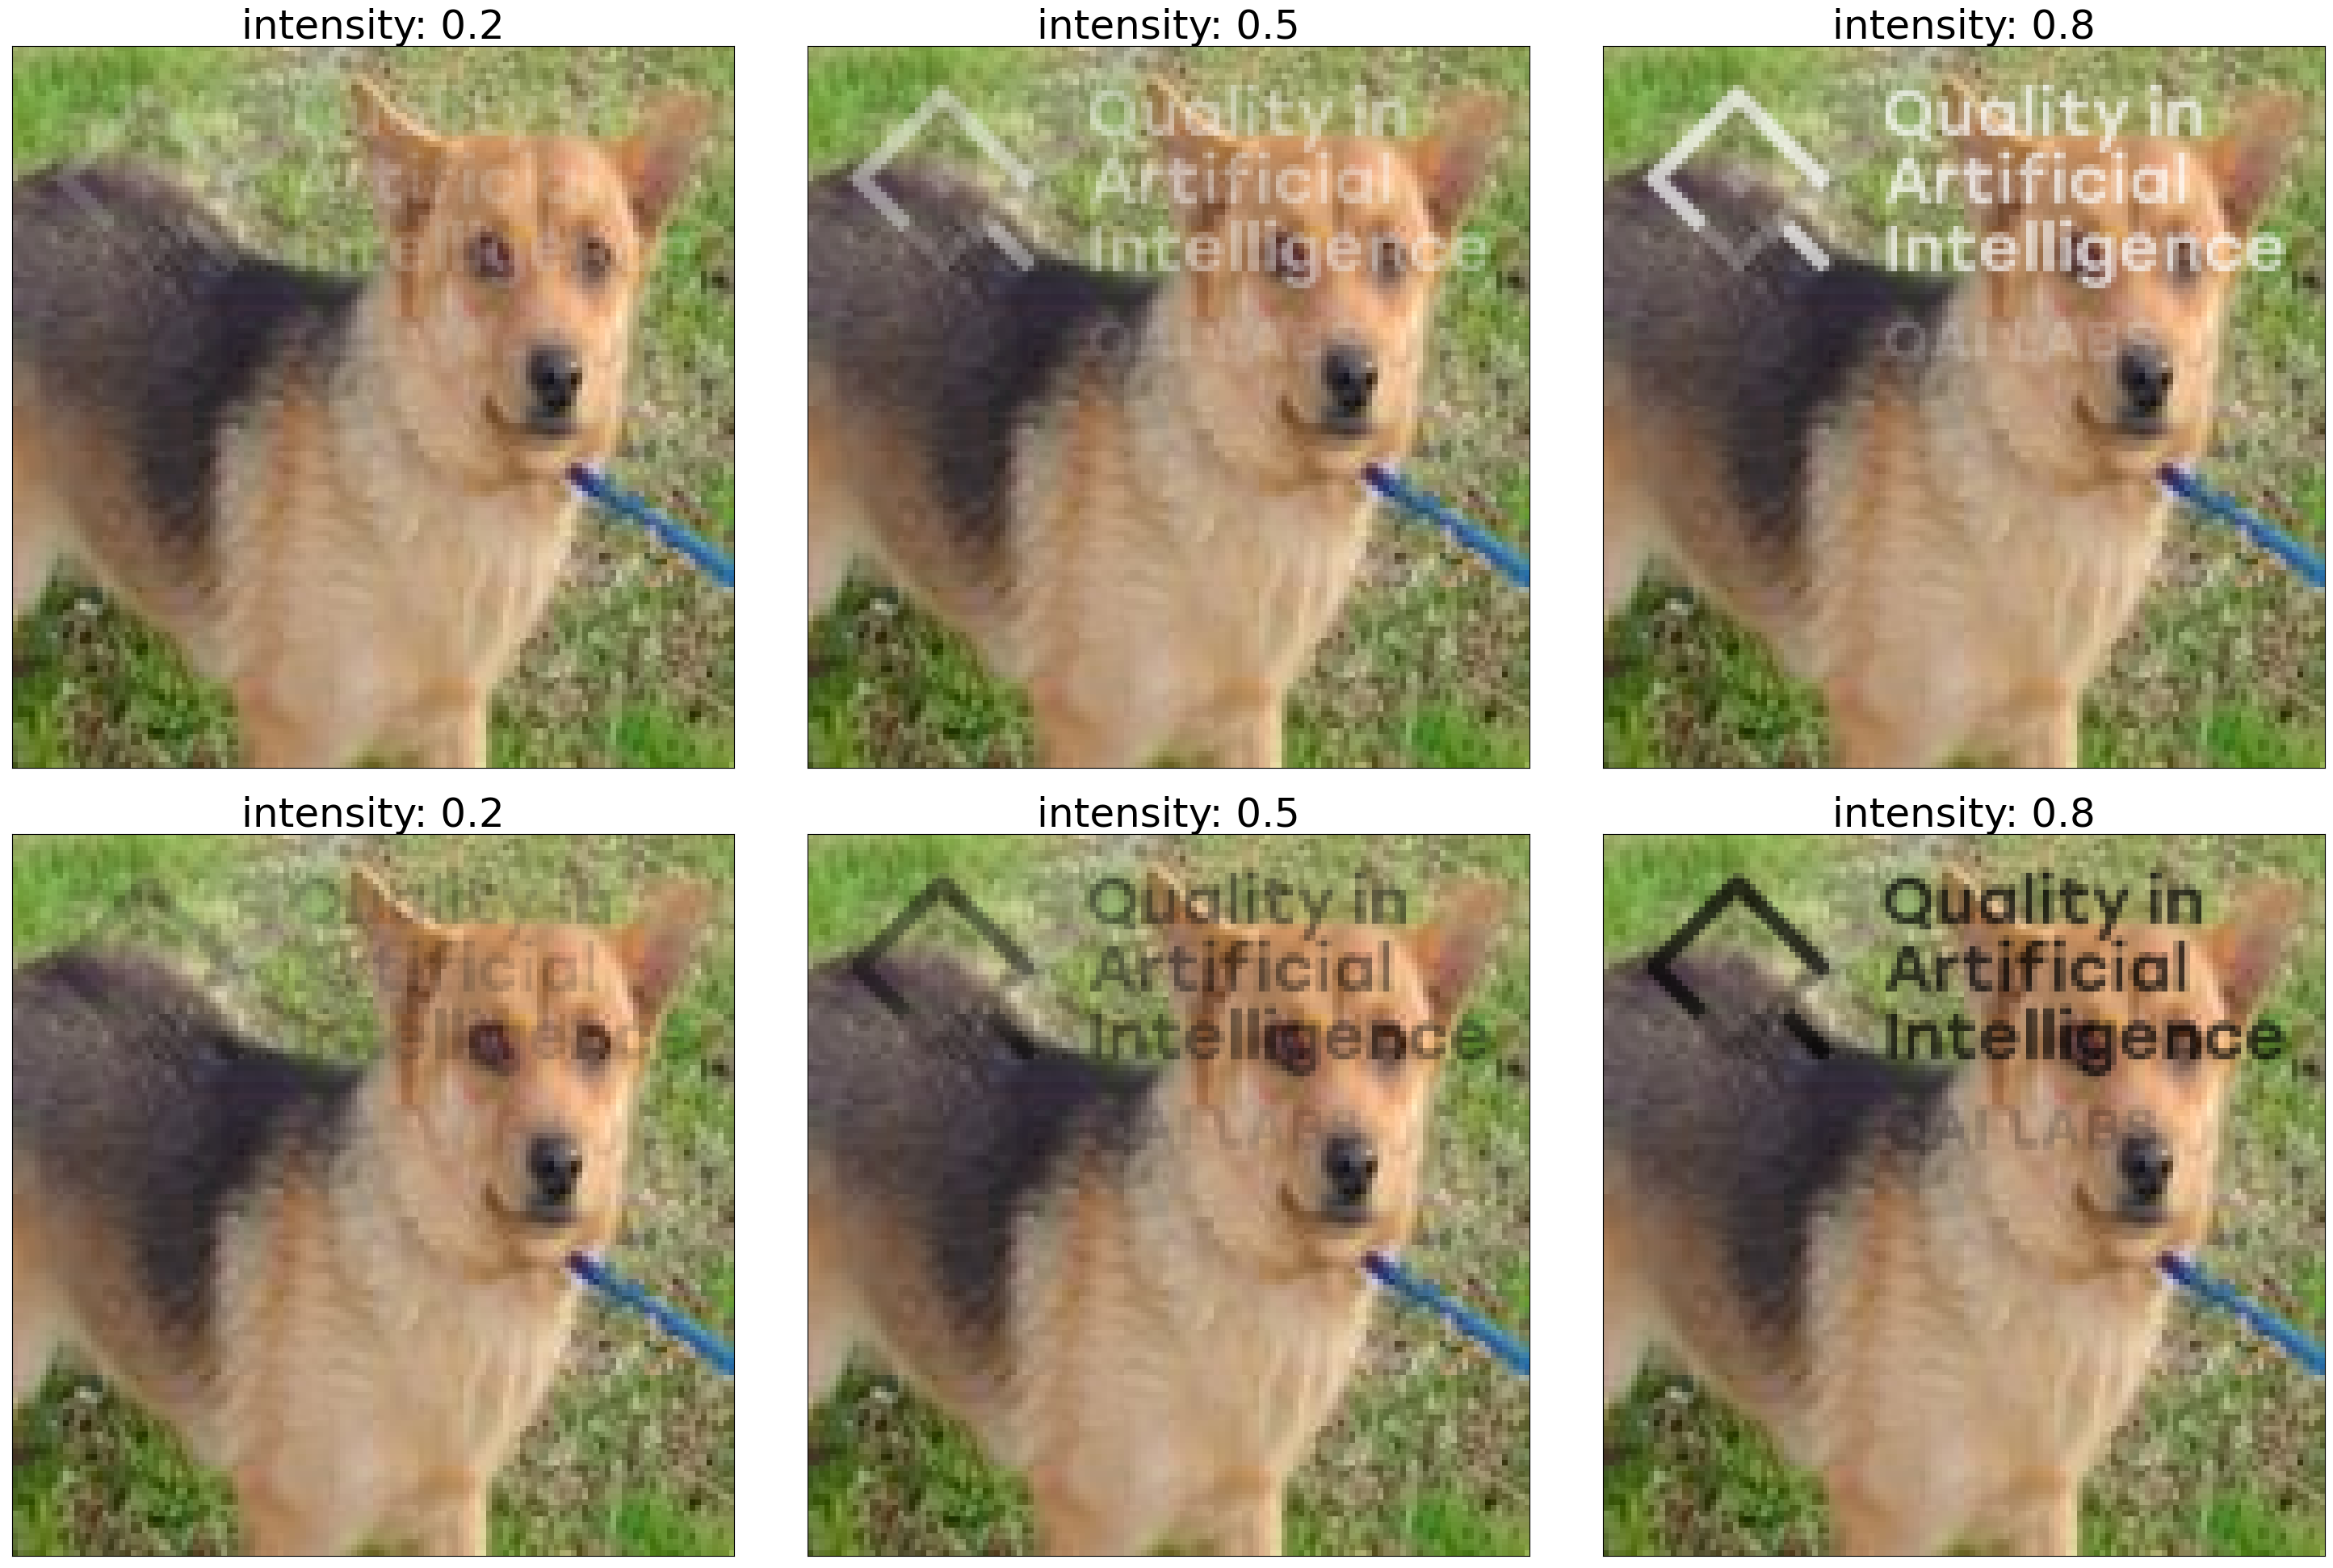

In [3]:
# folder='D:\\escola\\tese\\ML homework\\'
folder=''
original_image_path='./images/dog/dog.6053.jpg'
watermark_path_jpeg=folder+'watermark banner.jpg'
output_path=folder+'out\\'


image_size=(128,128)
plt.rcParams['font.size'] = 30
intensity_watermark=0.2
plt.figure(figsize=(30,20))
for i in range(3):
    white=1
    out_img=add_watermark(original_image_path,watermark_path_jpeg,intensity_watermark,image_size,white)
    plt.subplot(2,3,i+1)
    plt.imshow(out_img)
    plt.title(f'intensity: {intensity_watermark}')
    plt.yticks([])
    plt.xticks([])
    white=0
    out_img=add_watermark(original_image_path,watermark_path_jpeg,intensity_watermark,image_size,white)
    plt.subplot(2,3,i+4)
    plt.imshow(out_img)
    plt.title(f'intensity: {intensity_watermark}')
    intensity_watermark+=0.3
    plt.yticks([])
    plt.xticks([])
plt.tight_layout()

In [15]:
#creation of the datasets - this didn't work for me as I didn't have the data in images/cat/train form, just images/cat/cat.XXX.jpg (benny)
# #cat=0
# #dog=0
# from os import listdir
# from os.path import isfile, join

# # folder='D:\\escola\\tese\\ML homework\\'
# folder=''
# image_size=(128,128)
# cat_names_train = [folder+'images\\cat\\train\\'+f for f in listdir(folder+'images\\cat\\train\\') if isfile(join(folder+'images\\cat\\train\\', f))]
# cat_names_test = [folder+'images\\cat\\test\\'+f for f in listdir(folder+'images\\cat\\test\\') if isfile(join(folder+'images\\cat\\test\\', f))]
# cat_names_val = [folder+'images\\cat\\val\\'+f for f in listdir(folder+'images\\cat\\val\\') if isfile(join(folder+'images\\cat\\val\\', f))]


# dog_names_train = [folder+'images\\dog\\train\\'+f for f in listdir(folder+'images\\dog\\train\\') if isfile(join(folder+'images\\dog\\train\\', f))]
# dog_names_test = [folder+'images\\dog\\test\\'+f for f in listdir(folder+'images\\dog\\test\\') if isfile(join(folder+'images\\dog\\test\\', f))]
# dog_names_val = [folder+'images\\dog\\val\\'+f for f in listdir(folder+'images\\dog\\val\\') if isfile(join(folder+'images\\dog\\val\\', f))]

# import random
# # random.seed(0)
# # dataset_images_cats=random.sample(cat_names,k=6000)
# # dataset_images_dogs=random.sample(dog_names,k=6000)


FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'images\\cat\\train\\'

In [8]:
import random
from glob import glob
random.seed(0)
# random.sample(cat_names,k=6000)
cat_paths = glob('./images/cat/*')
dog_paths = glob('./images/dog/*')
print('total dogs and cats:', len(dog_paths), len(cat_paths))

total dogs and cats: 6000 6000


In [9]:
inds = list(range(6000))

train_inds = random.sample(inds, k=3000)

inds = list(np.delete(inds, np.where(train_inds==inds)))

val_inds = random.sample(inds, k=1500)
inds = list(np.delete(inds, np.where(val_inds==inds)))

test_inds = random.sample(inds, k=1500)

In [10]:
# no overlapping inds between sets
print(np.where(train_inds == val_inds))
print(np.where(train_inds == test_inds))
print(np.where(test_inds == val_inds))


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [11]:
cat_names_train = list(np.array(cat_paths)[train_inds])
cat_names_val = list(np.array(cat_paths)[val_inds])
cat_names_test = list(np.array(cat_paths)[test_inds])

dog_names_train = list(np.array(dog_paths)[train_inds])
dog_names_val = list(np.array(dog_paths)[val_inds])
dog_names_test = list(np.array(dog_paths)[test_inds])

In [12]:

def save_images(percentage_watermark,list_files,watermark_path,image_size,intensity_watermak,output_folder,white_bool):
    with_watermark=random.sample(list_files,k=int(len(list_files)*percentage_watermark))
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    n_water=0
    n_n_water=0

    for image in list_files:
        if image in with_watermark:
            out_im=add_watermark(image,watermark_path,intensity_watermak,image_size,white_bool)
            n_water+=1
        else:
            out_im=Image.open(image)
            out_im = out_im.resize(image_size)
            out_im=np.array(out_im)
            n_n_water+=1
            
        n=image.rfind('\\')
        plt.imsave(output_folder+image[n+1:],out_im)

    print('number of images with watermark:',n_water)
    print('number of images without watermark:',n_n_water)

Supressor 
+  50% each class has the watermark

In [6]:
# folder='D:\\escola\\tese\\ML homework\\'
folder=''
watermark_path_jpeg=folder+'watermark banner.jpg'
image_size=(128,128)
i=0.8

In [63]:

# output_folder='D:\\escola\\tese\\ML homework\\dataset_supressor\\'
output_folder='./artifacts/dataset_supressor/'
save_images(0.5,cat_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(0.5,cat_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(0.5,cat_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)
print()
save_images(0.5,dog_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(0.5,dog_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(0.5,dog_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)

number of images with watermark: 1500
number of images without watermark: 1500
number of images with watermark: 750
number of images without watermark: 750
number of images with watermark: 750
number of images without watermark: 750

number of images with watermark: 1500
number of images without watermark: 1500
number of images with watermark: 750
number of images without watermark: 750
number of images with watermark: 750
number of images without watermark: 750


Confounder 
+ 20% of cat class has watermark
+ 80% of dog class has watermark

In [64]:

# output_folder='D:\\escola\\tese\\ML homework\\dataset_confounder\\'
output_folder='./artifacts/dataset_confounder/'

save_images(0.2,cat_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(0.2,cat_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(0.2,cat_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)
print()
save_images(0.8,dog_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(0.8,dog_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(0.8,dog_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)

number of images with watermark: 600
number of images without watermark: 2400
number of images with watermark: 300
number of images without watermark: 1200
number of images with watermark: 300
number of images without watermark: 1200

number of images with watermark: 2400
number of images without watermark: 600
number of images with watermark: 1200
number of images without watermark: 300
number of images with watermark: 1200
number of images without watermark: 300


In [65]:

# output_folder='D:\\escola\\tese\\ML homework\\no_watermark\\'
output_folder='./artifacts/no_watermark/'

save_images(0,cat_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(0,cat_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(0,cat_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)
print()
save_images(0,dog_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(0,dog_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(0,dog_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)

number of images with watermark: 0
number of images without watermark: 3000
number of images with watermark: 0
number of images without watermark: 1500
number of images with watermark: 0
number of images without watermark: 1500

number of images with watermark: 0
number of images without watermark: 3000
number of images with watermark: 0
number of images without watermark: 1500
number of images with watermark: 0
number of images without watermark: 1500


In [13]:
# output_folder='D:\\escola\\tese\\ML homework\\dataset_supressor\\'
output_folder='./artifacts/dataset_allwatermark/'
save_images(1,cat_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(1,cat_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(1,cat_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)
print()
save_images(1,dog_names_train,watermark_path_jpeg,image_size,i,output_folder+'train/',1)
save_images(1,dog_names_test,watermark_path_jpeg,image_size,i,output_folder+'test/',1)
save_images(1,dog_names_val,watermark_path_jpeg,image_size,i,output_folder+'val/',1)

number of images with watermark: 3000
number of images without watermark: 0
number of images with watermark: 1500
number of images without watermark: 0
number of images with watermark: 1500
number of images without watermark: 0

number of images with watermark: 3000
number of images without watermark: 0
number of images with watermark: 1500
number of images without watermark: 0
number of images with watermark: 1500
number of images without watermark: 0


In [14]:
cat_names_test

['./images/cat\\cat.1877.jpg',
 './images/cat\\cat.3645.jpg',
 './images/cat\\cat.3844.jpg',
 './images/cat\\cat.2138.jpg',
 './images/cat\\cat.3247.jpg',
 './images/cat\\cat.2888.jpg',
 './images/cat\\cat.838.jpg',
 './images/cat\\cat.5805.jpg',
 './images/cat\\cat.2236.jpg',
 './images/cat\\cat.4068.jpg',
 './images/cat\\cat.1201.jpg',
 './images/cat\\cat.6157.jpg',
 './images/cat\\cat.1571.jpg',
 './images/cat\\cat.2370.jpg',
 './images/cat\\cat.3948.jpg',
 './images/cat\\cat.4114.jpg',
 './images/cat\\cat.1576.jpg',
 './images/cat\\cat.1565.jpg',
 './images/cat\\cat.6233.jpg',
 './images/cat\\cat.5386.jpg',
 './images/cat\\cat.2845.jpg',
 './images/cat\\cat.5116.jpg',
 './images/cat\\cat.1496.jpg',
 './images/cat\\cat.2592.jpg',
 './images/cat\\cat.3419.jpg',
 './images/cat\\cat.4458.jpg',
 './images/cat\\cat.5293.jpg',
 './images/cat\\cat.879.jpg',
 './images/cat\\cat.5689.jpg',
 './images/cat\\cat.1723.jpg',
 './images/cat\\cat.225.jpg',
 './images/cat\\cat.2177.jpg',
 './images/

In [19]:
no_mark_names = [i.split('\\')[-1] for i in glob('./artifacts/no_watermark/test/cat*')]
no_mark_names

['cat.1003.jpg',
 'cat.1009.jpg',
 'cat.1010.jpg',
 'cat.1011.jpg',
 'cat.1017.jpg',
 'cat.102.jpg',
 'cat.1020.jpg',
 'cat.1021.jpg',
 'cat.1029.jpg',
 'cat.103.jpg',
 'cat.1035.jpg',
 'cat.1038.jpg',
 'cat.1047.jpg',
 'cat.1048.jpg',
 'cat.1052.jpg',
 'cat.1060.jpg',
 'cat.1061.jpg',
 'cat.1066.jpg',
 'cat.1071.jpg',
 'cat.1074.jpg',
 'cat.1075.jpg',
 'cat.1079.jpg',
 'cat.1082.jpg',
 'cat.1088.jpg',
 'cat.1091.jpg',
 'cat.1096.jpg',
 'cat.11.jpg',
 'cat.1100.jpg',
 'cat.1101.jpg',
 'cat.1102.jpg',
 'cat.1104.jpg',
 'cat.1108.jpg',
 'cat.1112.jpg',
 'cat.1115.jpg',
 'cat.1121.jpg',
 'cat.1126.jpg',
 'cat.1129.jpg',
 'cat.113.jpg',
 'cat.1131.jpg',
 'cat.1132.jpg',
 'cat.1136.jpg',
 'cat.1140.jpg',
 'cat.1144.jpg',
 'cat.1145.jpg',
 'cat.1148.jpg',
 'cat.1150.jpg',
 'cat.1159.jpg',
 'cat.116.jpg',
 'cat.1160.jpg',
 'cat.1167.jpg',
 'cat.1173.jpg',
 'cat.1177.jpg',
 'cat.1179.jpg',
 'cat.1181.jpg',
 'cat.1185.jpg',
 'cat.1186.jpg',
 'cat.1190.jpg',
 'cat.1192.jpg',
 'cat.1197.jpg',
 'c

In [20]:
yes_mark_names = [i.split('\\')[-1] for i in glob('./artifacts/dataset_allwatermark/test/cat*')]
yes_mark_names

['cat.1003.jpg',
 'cat.1009.jpg',
 'cat.1010.jpg',
 'cat.1011.jpg',
 'cat.1017.jpg',
 'cat.102.jpg',
 'cat.1020.jpg',
 'cat.1021.jpg',
 'cat.1029.jpg',
 'cat.103.jpg',
 'cat.1035.jpg',
 'cat.1038.jpg',
 'cat.1047.jpg',
 'cat.1048.jpg',
 'cat.1052.jpg',
 'cat.1060.jpg',
 'cat.1061.jpg',
 'cat.1066.jpg',
 'cat.1071.jpg',
 'cat.1074.jpg',
 'cat.1075.jpg',
 'cat.1079.jpg',
 'cat.1082.jpg',
 'cat.1088.jpg',
 'cat.1091.jpg',
 'cat.1096.jpg',
 'cat.11.jpg',
 'cat.1100.jpg',
 'cat.1101.jpg',
 'cat.1102.jpg',
 'cat.1104.jpg',
 'cat.1108.jpg',
 'cat.1112.jpg',
 'cat.1115.jpg',
 'cat.1121.jpg',
 'cat.1126.jpg',
 'cat.1129.jpg',
 'cat.113.jpg',
 'cat.1131.jpg',
 'cat.1132.jpg',
 'cat.1136.jpg',
 'cat.1140.jpg',
 'cat.1144.jpg',
 'cat.1145.jpg',
 'cat.1148.jpg',
 'cat.1150.jpg',
 'cat.1159.jpg',
 'cat.116.jpg',
 'cat.1160.jpg',
 'cat.1167.jpg',
 'cat.1173.jpg',
 'cat.1177.jpg',
 'cat.1179.jpg',
 'cat.1181.jpg',
 'cat.1185.jpg',
 'cat.1186.jpg',
 'cat.1190.jpg',
 'cat.1192.jpg',
 'cat.1197.jpg',
 'c

In [26]:
len(np.where(np.array(no_mark_names) == np.array(yes_mark_names))[0])

1500

# create train, val, test datasets

In [27]:

def create_datasets(folder,files):
    dataset=[]
    for img in files:
        if img.find('cat')!=-1:
            image = np.asarray(Image.open(folder+img))
            dataset.append([image,0])

        elif img.find('dog')!=-1:
            image = np.asarray(Image.open(folder+img))
            dataset.append([image,1])

    return dataset



## confounder

In [67]:
from os import listdir
from os.path import isfile, join

In [68]:
# folder_test='D:\\escola\\tese\\ML homework\\dataset_confounder\\test\\'
folder_test='./artifacts/dataset_confounder/test/'
# folder_train='D:\\escola\\tese\\ML homework\\dataset_confounder\\train\\'
folder_train='./artifacts/dataset_confounder/train/'
# folder_val='D:\\escola\\tese\\ML homework\\dataset_confounder\\val\\'
folder_val='./artifacts/dataset_confounder/val/'

files_train = [f for f in listdir(folder_train) if isfile(join(folder_train, f))]
files_test = [f for f in listdir(folder_test) if isfile(join(folder_test, f))]
files_val = [f for f in listdir(folder_val) if isfile(join(folder_val, f))]

confounder_train=create_datasets(folder_train,files_train)
confounder_test=create_datasets(folder_test,files_test)
confounder_val=create_datasets(folder_val,files_val)

with open('confounder_train128.pkl', 'wb') as f:
    pickle.dump(confounder_train, f)

with open('confounder_test128.pkl', 'wb') as f:
    pickle.dump(confounder_test, f)

with open('confounder_val128.pkl', 'wb') as f:
    pickle.dump(confounder_val, f)


## supressor


In [70]:
# folder_test='D:\\escola\\tese\\ML homework\\dataset_supressor\\test\\'
# folder_train='D:\\escola\\tese\\ML homework\\dataset_supressor\\train\\'
# folder_val='D:\\escola\\tese\\ML homework\\dataset_supressor\\val\\'

folder_test='./artifacts/dataset_supressor/test/'
folder_train='./artifacts/dataset_supressor/train/'
folder_val='./artifacts/dataset_supressor/val/'

files_train = [f for f in listdir(folder_train) if isfile(join(folder_train, f))]
files_test = [f for f in listdir(folder_test) if isfile(join(folder_test, f))]
files_val = [f for f in listdir(folder_val) if isfile(join(folder_val, f))]

supressor_train=create_datasets(folder_train,files_train)
supressor_validation=create_datasets(folder_val,files_val)
supressor_test=create_datasets(folder_test,files_test)


with open('suppressor_train128.pkl', 'wb') as f:
    pickle.dump(supressor_train, f)

with open('suppressor_validation128.pkl', 'wb') as f:
    pickle.dump(supressor_validation, f)

with open('suppressor_test128.pkl', 'wb') as f:
    pickle.dump(supressor_test, f)


## nothing

In [71]:
# folder_test='D:\\escola\\tese\\ML homework\\no_watermark\\test\\'
# folder_train='D:\\escola\\tese\\ML homework\\no_watermark\\train\\'
# folder_val='D:\\escola\\tese\\ML homework\\no_watermark\\val\\'

folder_test='./artifacts/no_watermark/test/'
folder_train='./artifacts/no_watermark/train/'
folder_val='./artifacts/no_watermark/val/'

files_train = [f for f in listdir(folder_train) if isfile(join(folder_train, f))]
files_test = [f for f in listdir(folder_test) if isfile(join(folder_test, f))]
files_val = [f for f in listdir(folder_val) if isfile(join(folder_val, f))]

no_mark_train=create_datasets(folder_train,files_train)
no_mark_validation=create_datasets(folder_val,files_val)
no_mark_test=create_datasets(folder_test,files_test)

with open('no_mark_train128.pkl', 'wb') as f:
    pickle.dump(no_mark_train, f)

with open('no_mark_validation128.pkl', 'wb') as f:
    pickle.dump(no_mark_validation, f)

with open('no_mark_test128.pkl', 'wb') as f:
    pickle.dump(no_mark_test, f)

## All marks
For the first experiment of comparing with vs without marks, equivalent to no_mark test set... but with a watermark in every sample

In [28]:
folder_test='./artifacts/dataset_allwatermark/test/'

files_test = [f for f in listdir(folder_test) if isfile(join(folder_test, f))]

yes_mark_test=create_datasets(folder_test,files_test)

with open('mark_all128.pkl', 'wb') as f:
    pickle.dump(yes_mark_test, f)

For each of the datasets:
+ the training set has 3000 cats and 3000 dog images.
+ the test set has 1500 cats and 1500 dogs images.
+ the validation set has 1500 cats and 1500 dogs images.

The images are 128x128.

The watermark intensity is 0.8. 

The confounder sets 80% of the images that are dogs have a watermark and only 20% of the cat images have the watermark.

The surpressor sets have 50% images with watermark for both cats and dogs.

The no_mark sets have no watermarks.